In [128]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import copy
import math
import random
import time
# np.set_printoptions(suppress=True)

## Meta Params

In [129]:
NUMBER_CORNERS_TO_TRACK = 100
LK_PARAMS = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
INLIER_PERCENTAGE = 0.90 # Percentage of total images/cameras for which a feature should be inlier according to homography

## Params to be set along the code

In [130]:
REFERENCE_IMAGE = ""
FEATURES = "" # (n,1,2), n features with their coordinates in the reference image
IMAGES = ""
FEATURE_TRACKING = "" #For every feature, for every camera the coordinates of the feature => list of list of tuples
CAMERA_TRACKING = "" #for every camera, for every feature the coordinates of the feature => numpy array (M,N,2) => M camera, N features
NUMBER_CAMERAS = 0
NUMBER_FEATURES = 0

## Helper Functions

In [131]:
def convert(feat_cam):
    cam_feat = np.zeros((len(feat_cam[0]),len(feat_cam),2))
    for i in range(len(feat_cam)):
        for j in range(len(feat_cam[i])):
            cam_feat[j][i] = np.array(feat_cam[i][j])
    return cam_feat

In [132]:
def getFramesFromVideo(path):
    cam = cv2.VideoCapture(path)
    frames = []
    ret,frame = cam.read()
    frames.append(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
    while(ret):
        ret,frame = cam.read()
        if frame is None:
            continue
        frames.append(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
    return frames

In [133]:
def getGrayscaleImage(image):
    grayImage = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    return grayImage

In [134]:
def displayCorners(image,corners):
    plt.imsave("../output/original_image.jpg", image) 
    corners = np.intp(corners)
    for i in corners:
        x,y = i.ravel()
        cv2.circle(image,(x,y),3,255,-1)
    plt.imshow(image),plt.show()
    plt.show()
    plt.imsave("../output/corner_detected.jpg", image)

In [135]:
def printImage(image):
    plt.imshow(image)
    plt.show()

## Getting Data to Work On

In [136]:
images = getFramesFromVideo("../data/videos/v1.mp4")
REFERENCE_IMAGE = images[0]
IMAGES = images[1:]
print("Number of Frames",len(images))

Number of Frames 98


## Step 1: Initialization

### 1.1 Taking Image 0 as Reference Image and Tracking Corners Using Shi-Tomasi Corner Detection

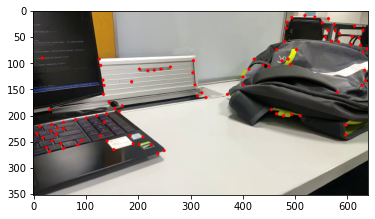

In [137]:
corners = cv2.goodFeaturesToTrack(getGrayscaleImage(np.copy(REFERENCE_IMAGE)),NUMBER_CORNERS_TO_TRACK,0.02,10)
displayCorners(np.copy(REFERENCE_IMAGE),corners)
FEATURES = np.copy(corners)

In [138]:
FEATURE_TRACKING = []
for x in FEATURES:
    FEATURE_TRACKING.append([(x[0][0],x[0][1])])

### 1.2 Tracking features from Reference Image accross all Images

In [139]:
for idx,image in enumerate(IMAGES):
    p1, st, err = cv2.calcOpticalFlowPyrLK(getGrayscaleImage(REFERENCE_IMAGE), getGrayscaleImage(image), FEATURES, None, **LK_PARAMS)
    if p1 is not None:
        p1 = p1[st==1]
        FEATURES = FEATURES[st==1]
        newTracking = []
        for i,x in enumerate(st):
            if x == 1:
                newTracking.append(FEATURE_TRACKING[i])
                newTracking[-1].append((p1[len(newTracking)-1][0],p1[len(newTracking)-1][1]))
        FEATURE_TRACKING = newTracking
        FEATURES = FEATURES.reshape((np.sum(st==1),1,2))

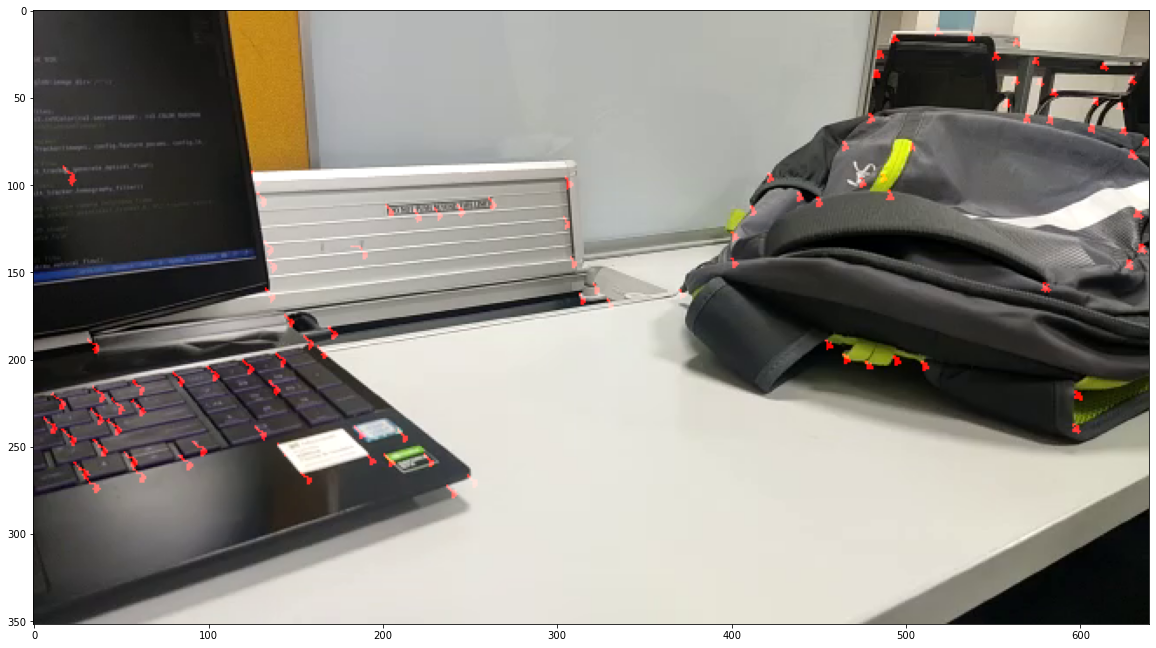

In [140]:
image = np.copy(REFERENCE_IMAGE)
mask = np.zeros_like(image)
for feature in FEATURE_TRACKING:
    feature = np.array(feature, np.int32).reshape((-1,1,2))
    cv2.polylines(mask, [feature], False, (255,0,0))
image = cv2.add(image, mask)
plt.imsave("../output/Flow.jpg", image)
plt.figure(figsize=[20,20])
plt.imshow(image)
plt.show()

### 1.3 Dealing with outliers in Feature Matching

In [141]:
CAMERA_TRACKING = convert(copy.deepcopy(FEATURE_TRACKING))

In [142]:
NUMBER_CAMERAS = CAMERA_TRACKING.shape[0]
NUMBER_FEATURES = CAMERA_TRACKING.shape[1]

In [143]:
count = np.zeros((CAMERA_TRACKING.shape[1],1))
for j in range(1,CAMERA_TRACKING.shape[0]):
    homography,inlier = cv2.findHomography(CAMERA_TRACKING[0,:,:],CAMERA_TRACKING[j,:,:],cv2.RANSAC,5.0)
    count += inlier
count[count < INLIER_PERCENTAGE*NUMBER_CAMERAS] = 0 
count[count >= INLIER_PERCENTAGE*NUMBER_CAMERAS] = 1
print("Number of features which qualify as inliers are",np.sum(count))

Number of features which qualify as inliers are 91.0


#### Displaying Outliers

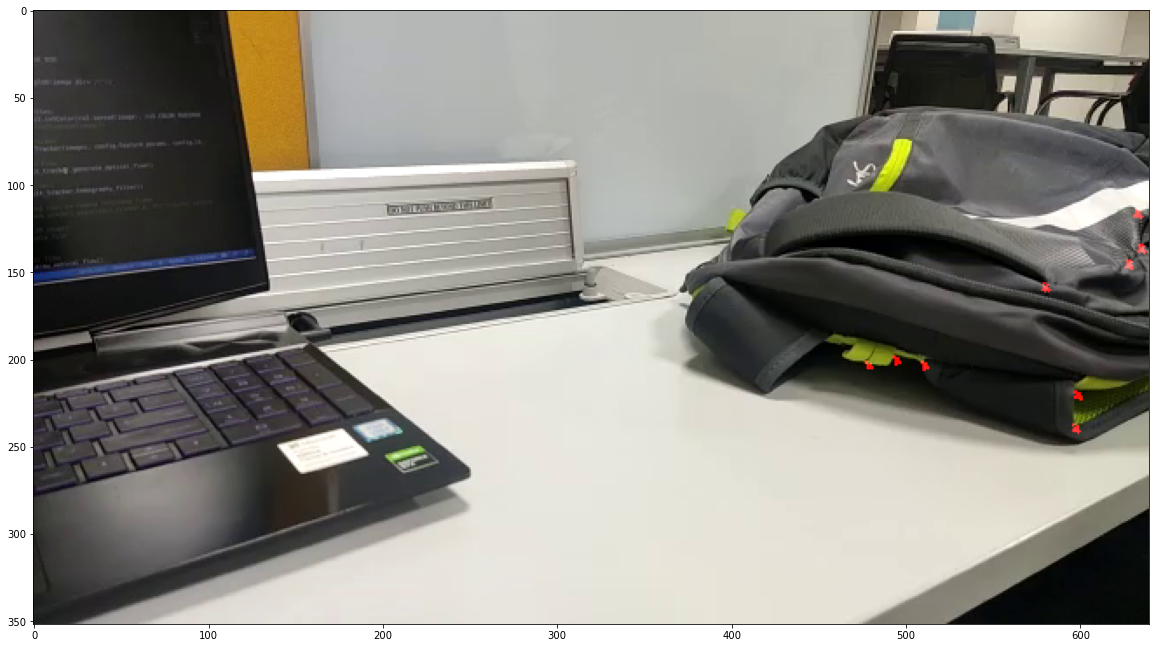

In [144]:
outlier_features = FEATURES[count==0]
outlier_features = outlier_features.reshape((np.sum(count==0),1,2))

newTracking = []
for i,x in enumerate(count):
    if x == 0:
        newTracking.append(FEATURE_TRACKING[i])

image = np.copy(REFERENCE_IMAGE)
mask = np.zeros_like(image)
for feature in newTracking:
    feature = np.array(feature, np.int32).reshape((-1,1,2))
    cv2.polylines(mask, [feature], False, (255,0,0))
image = cv2.add(image, mask)
plt.imsave("../output/Outliers_Flow.jpg", image)
plt.figure(figsize=[20,20])
plt.imshow(image)
plt.show()

#### Updating Params

In [145]:
FEATURES = FEATURES[count==1]
FEATURES = FEATURES.reshape((np.sum(count==1),1,2))
newTracking = []
for i,x in enumerate(count):
    if x == 1:
        newTracking.append(FEATURE_TRACKING[i])
FEATURE_TRACKING = newTracking
CAMERA_TRACKING = convert(copy.deepcopy(FEATURE_TRACKING))
NUMBER_CAMERAS = CAMERA_TRACKING.shape[0]
NUMBER_FEATURES = CAMERA_TRACKING.shape[1]
print("Number of Cameras",NUMBER_CAMERAS)
print("Number of Features",NUMBER_FEATURES)

Number of Cameras 98
Number of Features 91


#### Displaying Inliers

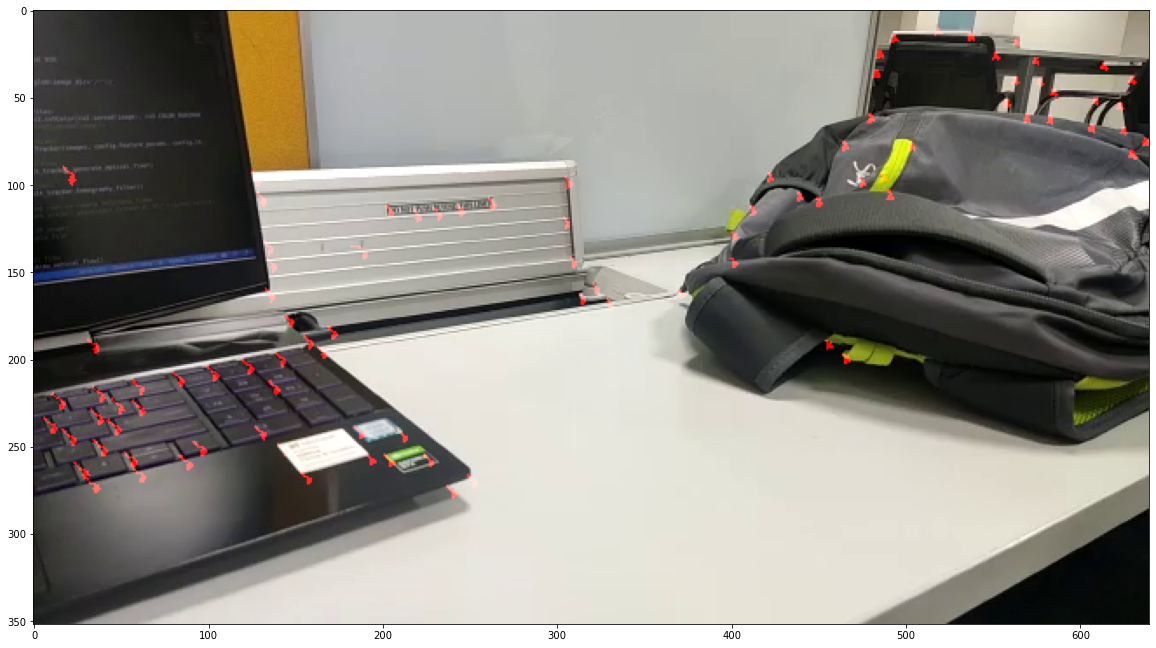

In [146]:
image = np.copy(REFERENCE_IMAGE)
mask = np.zeros_like(image)
for feature in FEATURE_TRACKING:
    feature = np.array(feature, np.int32).reshape((-1,1,2))
    cv2.polylines(mask, [feature], False, (255,0,0))
image = cv2.add(image, mask)
plt.imsave("../output/Inliers_Flow.jpg", image)
plt.figure(figsize=[20,20])
plt.imshow(image)
plt.show()